In [1]:
import os
from torchvision.transforms import Pad

## Dataset Object Definition + Creation

In [2]:
import os
import nibabel as nib
import numpy as np
from PIL import Image, ImageOps

from torch.utils.data import Dataset
from torchvision.transforms import Pad
from torchvision.transforms import ToTensor, Compose
import torchvision.transforms as transforms
import random



# Define a custom transform class to include random shifts and zooms
class RandomShiftZoom(transforms.RandomAffine):
    def __init__(self, shift_range, zoom_range, fill=0):
        # Define maximum translation as a fraction of the image size and a zoom range
        max_shift = shift_range * 2  # Define this as per your requirement, e.g., 0.1 for 10%
        zoom_min, zoom_max = zoom_range  # Define zoom range, e.g., (0.9, 1.1)
        super().__init__(degrees=0, translate=(max_shift, max_shift), scale=(zoom_min, zoom_max), fill=fill)


In [3]:
class ProstateMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None, exclude_patients=None, augment=False, max_size=620):
        self.root_dir = root_dir
        self.exclude_patients = exclude_patients if exclude_patients is not None else []
        self.augment = augment
        self.max_size = max_size
        self.samples = self._load_samples()

        self.augmentation_transforms = None
        if self.augment:
            self.augmentation_transforms = Compose([
                RandomShiftZoom(shift_range=0.1, zoom_range=(0.9, 1.1)),
                # Ensure that ToTensor is not applied here; it should be applied after all image manipulations
            ])
        self.transform = transform  # This should be a PIL-compatible transform

    def __getitem__(self, idx):
        mri_slice, label, file_path = self.samples[idx]
        mri_pil = Image.fromarray((mri_slice * 255).astype(np.uint8))

        if self.augment and self.augmentation_transforms:
            mri_pil = self.augmentation_transforms(mri_pil)

        # Check and apply padding if necessary
        if mri_pil.size[0] != self.max_size or mri_pil.size[1] != self.max_size:
            mri_pil = self.pad_to_max_size(mri_pil, self.max_size)

        # Apply any remaining transformations and convert to tensor
        if self.transform:
            mri_pil = self.transform(mri_pil)
        else:
            mri_pil = ToTensor()(mri_pil)

        return mri_pil, torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.samples)

    def _load_samples(self):
        samples = []
        for subject in os.listdir(self.root_dir):
            # Skip any excluded patients
            if subject in self.exclude_patients:
                continue

            subject_path = os.path.join(self.root_dir, subject)
            if os.path.isdir(subject_path):
                mri_path = os.path.join(subject_path, 'T2.nii.gz')
                mask_path = os.path.join(subject_path, 'prostate_mask.nii.gz')
                if os.path.isfile(mri_path) and os.path.isfile(mask_path):
                    mri_img = nib.load(mri_path).get_fdata().astype(np.float32)
                    mask_img = nib.load(mask_path).get_fdata().astype(np.float32)
                    mri_img = mri_img / np.max(mri_img)
                    for slice_idx in range(mri_img.shape[-1]):
                        label = 1 if np.any(mask_img[:, :, slice_idx] > 0) else 0
                        samples.append((mri_img[:, :, slice_idx], label, mri_path))
        return samples
    
    def pad_to_max_size(self, image, max_size):
        padding = (0, 0, max_size - image.width, max_size - image.height)
        return ImageOps.expand(image, padding, fill=0)


In [4]:
# Specify the root directory of the dataset
root_dir = '/data/csc4801/LaVioletteLab/LaVioletteData/'

# Initialize the dataset
exclude_patients = ['1278']
prostate_dataset = ProstateMRIDataset(root_dir=root_dir, exclude_patients=exclude_patients, augment=True)

## Display Sample For Sanity Check

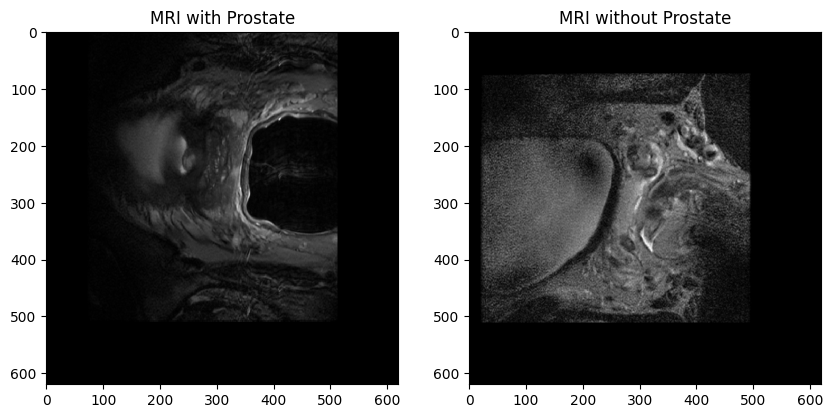

In [5]:
import matplotlib.pyplot as plt
import torch

# Find and display one example of an MRI slice with a prostate and one without
has_prostate = None
no_prostate = None

for mri_tensor, label in prostate_dataset:
    if label.item() == 1 and has_prostate is None:
        has_prostate = mri_tensor
    elif label.item() == 0 and no_prostate is None:
        no_prostate = mri_tensor
    if has_prostate is not None and no_prostate is not None:
        break

# Plotting the MRI slices
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(has_prostate.squeeze(), cmap='gray')
ax[0].set_title('MRI with Prostate')
ax[1].imshow(no_prostate.squeeze(), cmap='gray')
ax[1].set_title('MRI without Prostate')
plt.show()


## Model

In [6]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [7]:
class UNet(nn.Module):
    def __init__(self, n_channels, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = 1  # Still 1 for binary classification
        self.bilinear = bilinear

        # Initialize U-Net layers as before
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, self.n_classes)

    def forward(self, x):
        # U-Net forward pass remains unchanged up to the output layer
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        # Global Average Pooling before the final output layer
        x = torch.mean(x, dim=[2, 3], keepdim=True)
        
        # Final output layer
        logits = self.outc(x)
        return torch.sigmoid(logits.view(-1))


In [8]:
# Create the model, now with a single output channel
model = UNet(n_channels=1, bilinear=True)  # Specify if you want to use bilinear upscaling

# Moving the model to a GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Use BCELoss for binary classification after sigmoid activation
criterion = nn.BCELoss()

## Loop

In [9]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Data loading for training and validation
batch_size = 8

# Count the number of instances for each class
num_prostate = len([label for _, label in prostate_dataset if label == 1])
num_no_prostate = len(prostate_dataset) - num_prostate

# Determine the number of samples to include from each class for balancing
num_samples_per_class = min(num_prostate, num_no_prostate)

# Create a balanced training dataset
prostate_indices = [i for i, (_, label) in enumerate(prostate_dataset) if label == 1]
no_prostate_indices = [i for i, (_, label) in enumerate(prostate_dataset) if label == 0]

# Shuffle indices to ensure random selection
random.shuffle(prostate_indices)
random.shuffle(no_prostate_indices)

# Select equal number of samples from each class
balanced_indices = prostate_indices[:num_samples_per_class] + no_prostate_indices[:num_samples_per_class]
random.shuffle(balanced_indices)  # Shuffle the combined indices to mix classes

# Use the balanced indices to create a subset for the training dataset
balanced_train_dataset = torch.utils.data.Subset(prostate_dataset, balanced_indices)

# Correct the split for the training dataset
train_size_balanced = int(len(balanced_train_dataset) * 0.7)
validation_size_balanced = len(balanced_train_dataset) - train_size_balanced  # This is now correct

train_dataset, _ = random_split(balanced_train_dataset, [train_size_balanced, validation_size_balanced])

# For the validation dataset, you should split the original dataset
# Subtract the balanced training set size from the original dataset size for the validation size
validation_size_original = len(prostate_dataset) - train_size_balanced

# Now split the original dataset to create the validation dataset
_, validation_dataset = random_split(prostate_dataset, [train_size_balanced, validation_size_original])

# Initialize DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)


In [10]:
import gc
gc.collect()

0

In [11]:
import torch
from tqdm.notebook import tqdm

def train_model_with_tqdm(model, criterion, optimizer, train_dataloader, validation_dataloader, num_epochs=25, checkpoint_path='model_checkpoint.pth'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    best_val_accuracy = 0  # Track the best validation accuracy

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device).view(-1)
            optimizer.zero_grad()
            outputs = model(inputs)
            predictions = (outputs > 0.5).float()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            train_bar.set_postfix(loss=running_loss/total, accuracy=100. * correct / total)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in validation_dataloader:
                inputs, labels = inputs.to(device), labels.to(device).view(-1)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels.float())
                running_val_loss += val_loss.item() * inputs.size(0)
                val_predictions = (outputs > 0.5).float()
                val_correct += (val_predictions == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = 100. * val_correct / val_total
        print(f'\nEpoch {epoch+1}/{num_epochs} - Validation Loss: {running_val_loss/val_total:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n')

        # Save checkpoint if this is the best model so far
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': running_val_loss/val_total,
                'accuracy': val_accuracy,
            }, checkpoint_path)
            print(f"Checkpoint saved: Epoch {epoch+1} with Validation Accuracy {val_accuracy:.2f}%")

In [12]:
# Assuming model, criterion, optimizer, train_dataloader, and validation_dataloader are already defined
train_model_with_tqdm(model, criterion, optimizer, train_dataloader, validation_dataloader, num_epochs=20)

Epoch 1/20 [Training]:   0%|          | 0/483 [00:00<?, ?it/s]


Epoch 1/20 - Validation Loss: 1.6588, Validation Accuracy: 47.31%

Checkpoint saved: Epoch 1 with Validation Accuracy 47.31%


Epoch 2/20 [Training]:   0%|          | 0/483 [00:00<?, ?it/s]


Epoch 2/20 - Validation Loss: 0.4863, Validation Accuracy: 76.07%

Checkpoint saved: Epoch 2 with Validation Accuracy 76.07%


Epoch 3/20 [Training]:   0%|          | 0/483 [00:00<?, ?it/s]


Epoch 3/20 - Validation Loss: 0.4131, Validation Accuracy: 82.67%

Checkpoint saved: Epoch 3 with Validation Accuracy 82.67%


Epoch 4/20 [Training]:   0%|          | 0/483 [00:00<?, ?it/s]


Epoch 4/20 - Validation Loss: 0.3168, Validation Accuracy: 87.71%

Checkpoint saved: Epoch 4 with Validation Accuracy 87.71%


Epoch 5/20 [Training]:   0%|          | 0/483 [00:00<?, ?it/s]


Epoch 5/20 - Validation Loss: 0.3697, Validation Accuracy: 85.15%



Epoch 6/20 [Training]:   0%|          | 0/483 [00:00<?, ?it/s]


Epoch 6/20 - Validation Loss: 0.3296, Validation Accuracy: 86.68%



Epoch 7/20 [Training]:   0%|          | 0/483 [00:00<?, ?it/s]


Epoch 7/20 - Validation Loss: 0.2413, Validation Accuracy: 91.25%

Checkpoint saved: Epoch 7 with Validation Accuracy 91.25%


Epoch 8/20 [Training]:   0%|          | 0/483 [00:00<?, ?it/s]


Epoch 8/20 - Validation Loss: 0.2923, Validation Accuracy: 88.80%



Epoch 9/20 [Training]:   0%|          | 0/483 [00:00<?, ?it/s]


Epoch 9/20 - Validation Loss: 0.2439, Validation Accuracy: 90.58%



Epoch 10/20 [Training]:   0%|          | 0/483 [00:00<?, ?it/s]


Epoch 10/20 - Validation Loss: 0.2618, Validation Accuracy: 90.61%



Epoch 11/20 [Training]:   0%|          | 0/483 [00:00<?, ?it/s]


Epoch 11/20 - Validation Loss: 0.2303, Validation Accuracy: 92.23%

Checkpoint saved: Epoch 11 with Validation Accuracy 92.23%


Epoch 12/20 [Training]:   0%|          | 0/483 [00:00<?, ?it/s]


Epoch 12/20 - Validation Loss: 0.2064, Validation Accuracy: 92.56%

Checkpoint saved: Epoch 12 with Validation Accuracy 92.56%


Epoch 13/20 [Training]:   0%|          | 0/483 [00:00<?, ?it/s]


Epoch 13/20 - Validation Loss: 0.2547, Validation Accuracy: 90.08%



Epoch 14/20 [Training]:   0%|          | 0/483 [00:00<?, ?it/s]


Epoch 14/20 - Validation Loss: 0.2332, Validation Accuracy: 91.33%



Epoch 15/20 [Training]:   0%|          | 0/483 [00:00<?, ?it/s]


Epoch 15/20 - Validation Loss: 0.1887, Validation Accuracy: 93.45%

Checkpoint saved: Epoch 15 with Validation Accuracy 93.45%


Epoch 16/20 [Training]:   0%|          | 0/483 [00:00<?, ?it/s]


Epoch 16/20 - Validation Loss: 0.2327, Validation Accuracy: 90.83%



Epoch 17/20 [Training]:   0%|          | 0/483 [00:00<?, ?it/s]


Epoch 17/20 - Validation Loss: 0.1660, Validation Accuracy: 94.12%

Checkpoint saved: Epoch 17 with Validation Accuracy 94.12%


Epoch 18/20 [Training]:   0%|          | 0/483 [00:00<?, ?it/s]


Epoch 18/20 - Validation Loss: 0.2011, Validation Accuracy: 92.67%



Epoch 19/20 [Training]:   0%|          | 0/483 [00:00<?, ?it/s]


Epoch 19/20 - Validation Loss: 0.1710, Validation Accuracy: 94.46%

Checkpoint saved: Epoch 19 with Validation Accuracy 94.46%


Epoch 20/20 [Training]:   0%|          | 0/483 [00:00<?, ?it/s]


Epoch 20/20 - Validation Loss: 0.1561, Validation Accuracy: 94.32%



In [13]:
#nipy

In [20]:
torch.save(model, 'model_identification_e20_l169')

In [15]:
# model = torch.load('model_e20_l02')

## Predictions

In [16]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a validation_dataloader to get your validation dataset
y_true = []
y_pred = []
y_scores = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in validation_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device).view(-1)
        outputs = model(inputs)
        # ADJUST THIS TO MODIFY FP OR FN, DEFUALT IS 0.5
        predictions = (outputs > 0.9).float()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())

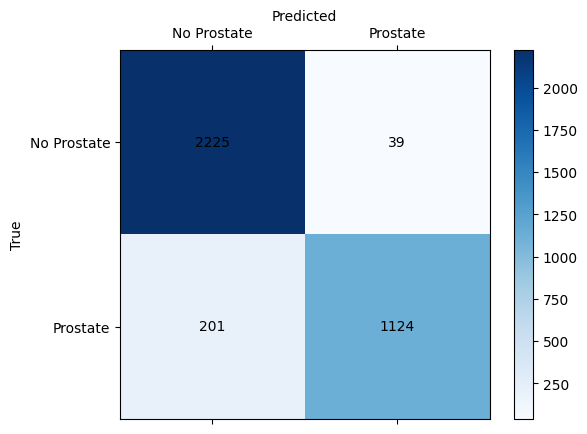

Number of images with prostate: 1325.0
Number of images without prostate: 2264.0


In [17]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Plot confusion matrix with values and modified label positions
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Set tick positions and labels with swapped order
ax.set_xticks([1, 0])
ax.set_yticks([1, 0])
ax.set_xticklabels(['Prostate', 'No Prostate'])
ax.set_yticklabels(['Prostate', 'No Prostate'])

# Move the x-axis label to the top
ax.xaxis.set_label_position('top') 
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

# Annotate the cells with the numeric values, adjusting for the swapped label order
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='black')

plt.show()

num_images_with_prostate = sum(y_true)
num_images_without_prostate = len(y_true) - num_images_with_prostate

print(f"Number of images with prostate: {num_images_with_prostate}")
print(f"Number of images without prostate: {num_images_without_prostate}")


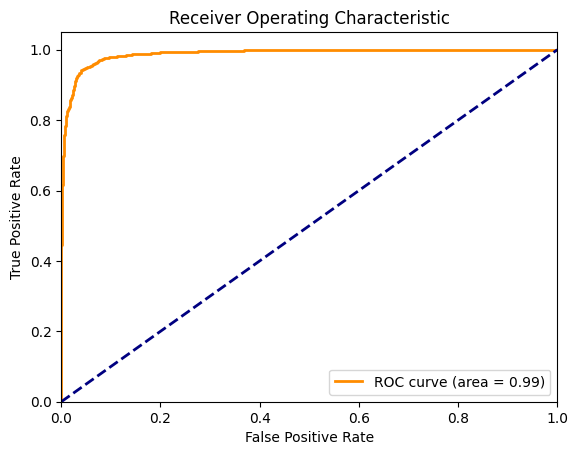

Total misclassified samples: 240


In [18]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Display some examples of misclassifications
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true != pred]
print(f"Total misclassified samples: {len(misclassified_indices)}")



## Problem Children

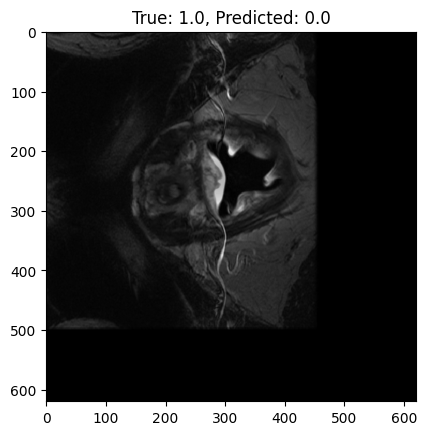

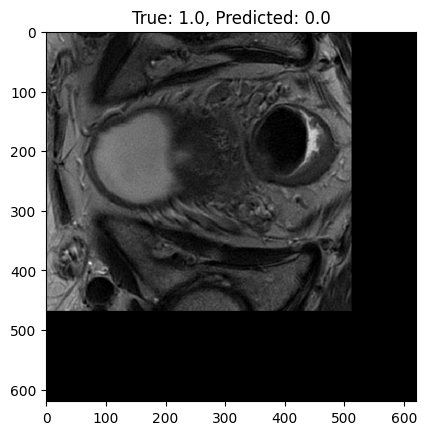

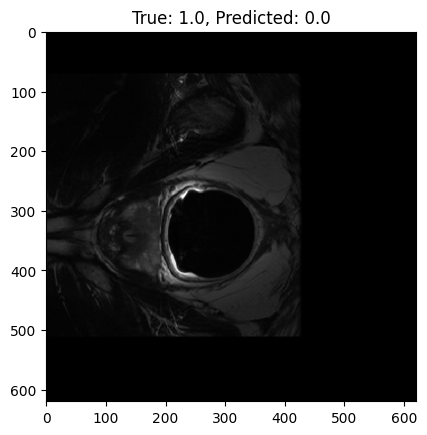

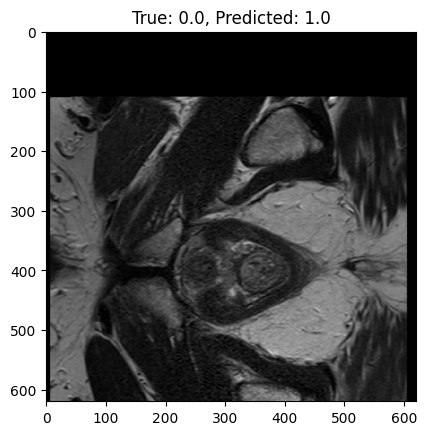

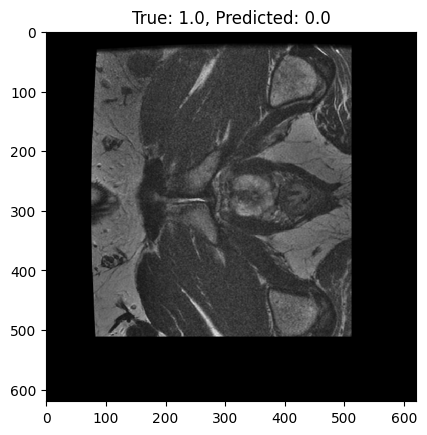

In [19]:
# Optionally show some misclassified images
# Adjust the number of examples according to your preference or screen space
for index in misclassified_indices[:5]:  # Show first 5 misclassified samples
    plt.figure()
    img = validation_dataloader.dataset[index][0].squeeze().cpu().numpy()  # Assuming dataset returns (image, label)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {y_true[index]}, Predicted: {y_pred[index]}")
    plt.show()